# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!pip install --q torchsummary

# Custom_Resnet

In [3]:
import torch.nn.functional as F

# Define a ResNet block with batch normalization
class MyResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization
        self.activation1 = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += shortcut
        x = self.activation1(x)
        return x

# Define the main ResNet model with batch normalization
class MyResNet(nn.Module):
    def __init__(self):
        super(MyResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        self.activation1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization
        self.activation2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.resblock1 = MyResNetBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization
        self.activation3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)  # Batch normalization
        self.activation4 = nn.ELU()
        self.resblock2 = MyResNetBlock(256, 256)

        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(256, 256)
        self.dense2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation2(x)
        x = self.maxpool1(x)

        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.activation3(x)
        x = self.maxpool2(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.activation4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.softmax(x)
        return x


In [ ]:
from torchsummary import summary

# Instantiate the model
model = MyResNet()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
               ELU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
               ELU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
       BatchNorm2d-9           [-1, 64, 16, 16]             128
              ELU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2d-12           [-1, 64, 16, 16]             128
              ELU-13           [-1, 64, 16, 16]               0
    MyResNetBlock-14           [-1, 64,

# Dataset

In [ ]:
# Data augmentation transformations for training data
data_augmentation_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),  # Randomly rotate the image by 15 degrees
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor values
])

# Data preprocessing transformations for test/validation data
data_preprocessing_test = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the tensor values
])


# Load CIFAR-10 dataset
# Training set with data augmentation
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_augmentation_train)
# Test set with data preprocessing
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_preprocessing_test)

# Splitting the training dataset into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
batch_size = 128
# Training data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Validation data loader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12343558.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyResNet().to(device)

In [ ]:
# Optimizer, Learning Rate Scheduler, and Loss Criterion
# Stochastic Gradient Descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Learning rate scheduler with step decay
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
# CrossEntropyLoss criterion for classification tasks
criterion = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
best_model_weights = None

# Number of epochs
epochs = 100

# Training loop
for epoch in range(1, epochs + 1):
    # Training
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total_samples += data.size(0)

        total_loss += loss.item()

    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy_train = correct / total_samples

    print(f'Train Epoch: {epoch}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy_train:.2}')

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy_val = correct / len(val_loader.dataset)
    print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {accuracy_val:.2f}')

    # Append values for plotting
    train_losses.append(average_loss)
    train_accuracies.append(accuracy_train)

    # Append values for plotting
    val_losses.append(val_loss)
    val_accuracies.append(accuracy_val)

    if accuracy_val > best_val_accuracy:
       best_val_accuracy = accuracy_val
       best_model_weights = model.state_dict()

    scheduler.step()

100%|██████████| 352/352 [00:42<00:00,  8.24it/s]


Train Epoch: 1, Average Loss: 0.0164, Accuracy: 0.37
Validation set: Average loss: 0.0163, Accuracy: 0.42


100%|██████████| 352/352 [00:30<00:00, 11.64it/s]


Train Epoch: 2, Average Loss: 0.0155, Accuracy: 0.48
Validation set: Average loss: 0.0157, Accuracy: 0.50


100%|██████████| 352/352 [00:30<00:00, 11.51it/s]


Train Epoch: 3, Average Loss: 0.0151, Accuracy: 0.54
Validation set: Average loss: 0.0154, Accuracy: 0.53


100%|██████████| 352/352 [00:30<00:00, 11.42it/s]


Train Epoch: 4, Average Loss: 0.0148, Accuracy: 0.57
Validation set: Average loss: 0.0151, Accuracy: 0.57


100%|██████████| 352/352 [00:30<00:00, 11.62it/s]


Train Epoch: 5, Average Loss: 0.0147, Accuracy: 0.58
Validation set: Average loss: 0.0151, Accuracy: 0.57


100%|██████████| 352/352 [00:30<00:00, 11.37it/s]


Train Epoch: 6, Average Loss: 0.0146, Accuracy: 0.6
Validation set: Average loss: 0.0155, Accuracy: 0.53


100%|██████████| 352/352 [00:29<00:00, 11.75it/s]


Train Epoch: 7, Average Loss: 0.0145, Accuracy: 0.61
Validation set: Average loss: 0.0149, Accuracy: 0.60


100%|██████████| 352/352 [00:30<00:00, 11.72it/s]


Train Epoch: 8, Average Loss: 0.0144, Accuracy: 0.62
Validation set: Average loss: 0.0150, Accuracy: 0.59


100%|██████████| 352/352 [00:30<00:00, 11.55it/s]


Train Epoch: 9, Average Loss: 0.0143, Accuracy: 0.63
Validation set: Average loss: 0.0148, Accuracy: 0.61


100%|██████████| 352/352 [00:30<00:00, 11.62it/s]


Train Epoch: 10, Average Loss: 0.0142, Accuracy: 0.64
Validation set: Average loss: 0.0147, Accuracy: 0.61


100%|██████████| 352/352 [00:30<00:00, 11.58it/s]


Train Epoch: 11, Average Loss: 0.0142, Accuracy: 0.65
Validation set: Average loss: 0.0147, Accuracy: 0.62


100%|██████████| 352/352 [00:30<00:00, 11.72it/s]


Train Epoch: 12, Average Loss: 0.0141, Accuracy: 0.65
Validation set: Average loss: 0.0146, Accuracy: 0.62


100%|██████████| 352/352 [00:30<00:00, 11.67it/s]


Train Epoch: 13, Average Loss: 0.0141, Accuracy: 0.66
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:30<00:00, 11.41it/s]


Train Epoch: 14, Average Loss: 0.0140, Accuracy: 0.67
Validation set: Average loss: 0.0144, Accuracy: 0.66


100%|██████████| 352/352 [00:30<00:00, 11.71it/s]


Train Epoch: 15, Average Loss: 0.0139, Accuracy: 0.68
Validation set: Average loss: 0.0143, Accuracy: 0.67


100%|██████████| 352/352 [00:30<00:00, 11.57it/s]


Train Epoch: 16, Average Loss: 0.0139, Accuracy: 0.68
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:30<00:00, 11.72it/s]


Train Epoch: 17, Average Loss: 0.0139, Accuracy: 0.69
Validation set: Average loss: 0.0144, Accuracy: 0.66


100%|██████████| 352/352 [00:29<00:00, 11.80it/s]


Train Epoch: 18, Average Loss: 0.0138, Accuracy: 0.7
Validation set: Average loss: 0.0141, Accuracy: 0.69


100%|██████████| 352/352 [00:30<00:00, 11.54it/s]


Train Epoch: 19, Average Loss: 0.0138, Accuracy: 0.7
Validation set: Average loss: 0.0143, Accuracy: 0.68


100%|██████████| 352/352 [00:30<00:00, 11.68it/s]


Train Epoch: 20, Average Loss: 0.0138, Accuracy: 0.7
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:30<00:00, 11.49it/s]


Train Epoch: 21, Average Loss: 0.0137, Accuracy: 0.71
Validation set: Average loss: 0.0142, Accuracy: 0.68


100%|██████████| 352/352 [00:29<00:00, 11.75it/s]


Train Epoch: 22, Average Loss: 0.0137, Accuracy: 0.71
Validation set: Average loss: 0.0143, Accuracy: 0.68


100%|██████████| 352/352 [00:30<00:00, 11.67it/s]


Train Epoch: 23, Average Loss: 0.0136, Accuracy: 0.72
Validation set: Average loss: 0.0141, Accuracy: 0.69


100%|██████████| 352/352 [00:30<00:00, 11.47it/s]


Train Epoch: 24, Average Loss: 0.0136, Accuracy: 0.72
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.58it/s]


Train Epoch: 25, Average Loss: 0.0136, Accuracy: 0.72
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.62it/s]


Train Epoch: 26, Average Loss: 0.0136, Accuracy: 0.73
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:29<00:00, 11.75it/s]


Train Epoch: 27, Average Loss: 0.0136, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:29<00:00, 11.75it/s]


Train Epoch: 28, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.56it/s]


Train Epoch: 29, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:29<00:00, 11.79it/s]


Train Epoch: 30, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0141, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.70it/s]


Train Epoch: 31, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0142, Accuracy: 0.69


100%|██████████| 352/352 [00:30<00:00, 11.63it/s]


Train Epoch: 32, Average Loss: 0.0134, Accuracy: 0.74
Validation set: Average loss: 0.0139, Accuracy: 0.73


100%|██████████| 352/352 [00:29<00:00, 11.81it/s]


Train Epoch: 33, Average Loss: 0.0134, Accuracy: 0.74
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.44it/s]


Train Epoch: 34, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:29<00:00, 11.77it/s]


Train Epoch: 35, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.73


100%|██████████| 352/352 [00:29<00:00, 11.82it/s]


Train Epoch: 36, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.73


100%|██████████| 352/352 [00:29<00:00, 11.81it/s]


Train Epoch: 37, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0140, Accuracy: 0.72


100%|██████████| 352/352 [00:29<00:00, 11.83it/s]


Train Epoch: 38, Average Loss: 0.0133, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.47it/s]


Train Epoch: 39, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.69it/s]


Train Epoch: 40, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0138, Accuracy: 0.73


100%|██████████| 352/352 [00:29<00:00, 11.83it/s]


Train Epoch: 41, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0138, Accuracy: 0.74


100%|██████████| 352/352 [00:30<00:00, 11.68it/s]


Train Epoch: 42, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.73


100%|██████████| 352/352 [00:30<00:00, 11.66it/s]


Train Epoch: 43, Average Loss: 0.0132, Accuracy: 0.77
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.59it/s]


Train Epoch: 44, Average Loss: 0.0132, Accuracy: 0.77
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.63it/s]


Train Epoch: 45, Average Loss: 0.0132, Accuracy: 0.77
Validation set: Average loss: 0.0139, Accuracy: 0.73


100%|██████████| 352/352 [00:29<00:00, 11.84it/s]


Train Epoch: 46, Average Loss: 0.0132, Accuracy: 0.77
Validation set: Average loss: 0.0138, Accuracy: 0.74


100%|██████████| 352/352 [00:30<00:00, 11.58it/s]


Train Epoch: 47, Average Loss: 0.0132, Accuracy: 0.77
Validation set: Average loss: 0.0138, Accuracy: 0.73


100%|██████████| 352/352 [00:30<00:00, 11.68it/s]


Train Epoch: 48, Average Loss: 0.0132, Accuracy: 0.77
Validation set: Average loss: 0.0138, Accuracy: 0.74


100%|██████████| 352/352 [00:30<00:00, 11.48it/s]


Train Epoch: 49, Average Loss: 0.0132, Accuracy: 0.78
Validation set: Average loss: 0.0138, Accuracy: 0.73


100%|██████████| 352/352 [00:29<00:00, 11.74it/s]


Train Epoch: 50, Average Loss: 0.0131, Accuracy: 0.78
Validation set: Average loss: 0.0138, Accuracy: 0.74


100%|██████████| 352/352 [00:29<00:00, 11.84it/s]


Train Epoch: 51, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0135, Accuracy: 0.77


100%|██████████| 352/352 [00:30<00:00, 11.64it/s]


Train Epoch: 52, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0134, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.75it/s]


Train Epoch: 53, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0134, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.75it/s]


Train Epoch: 54, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0134, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.75it/s]


Train Epoch: 55, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:30<00:00, 11.70it/s]


Train Epoch: 56, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0134, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 12.03it/s]


Train Epoch: 57, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 12.09it/s]


Train Epoch: 58, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0134, Accuracy: 0.78


100%|██████████| 352/352 [00:28<00:00, 12.21it/s]


Train Epoch: 59, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.77it/s]


Train Epoch: 60, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0134, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 12.13it/s]


Train Epoch: 61, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.82it/s]


Train Epoch: 62, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0133, Accuracy: 0.79


100%|██████████| 352/352 [00:28<00:00, 12.17it/s]


Train Epoch: 63, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Train Epoch: 64, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 12.09it/s]


Train Epoch: 65, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:28<00:00, 12.27it/s]


Train Epoch: 66, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 12.08it/s]


Train Epoch: 67, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:28<00:00, 12.14it/s]


Train Epoch: 68, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:30<00:00, 11.55it/s]


Train Epoch: 69, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.83it/s]


Train Epoch: 70, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Train Epoch: 71, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.77it/s]


Train Epoch: 72, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0133, Accuracy: 0.80


100%|██████████| 352/352 [00:29<00:00, 11.97it/s]


Train Epoch: 73, Average Loss: 0.0127, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 12.07it/s]


Train Epoch: 74, Average Loss: 0.0127, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.84it/s]


Train Epoch: 75, Average Loss: 0.0127, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Train Epoch: 76, Average Loss: 0.0127, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.75it/s]


Train Epoch: 77, Average Loss: 0.0127, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.97it/s]


Train Epoch: 78, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.80


100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Train Epoch: 79, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.90it/s]


Train Epoch: 80, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Train Epoch: 81, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.89it/s]


Train Epoch: 82, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 12.03it/s]


Train Epoch: 83, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Train Epoch: 84, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.87it/s]


Train Epoch: 85, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.80


100%|██████████| 352/352 [00:29<00:00, 12.07it/s]


Train Epoch: 86, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.82it/s]


Train Epoch: 87, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.80


100%|██████████| 352/352 [00:29<00:00, 11.92it/s]


Train Epoch: 88, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.80


100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Train Epoch: 89, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Train Epoch: 90, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.80


100%|██████████| 352/352 [00:29<00:00, 12.09it/s]


Train Epoch: 91, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.78it/s]


Train Epoch: 92, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.80


100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Train Epoch: 93, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.93it/s]


Train Epoch: 94, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.94it/s]


Train Epoch: 95, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 12.10it/s]


Train Epoch: 96, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.80


100%|██████████| 352/352 [00:29<00:00, 11.93it/s]


Train Epoch: 97, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.80


100%|██████████| 352/352 [00:29<00:00, 11.83it/s]


Train Epoch: 98, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.80


100%|██████████| 352/352 [00:29<00:00, 11.94it/s]


Train Epoch: 99, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.80


100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Train Epoch: 100, Average Loss: 0.0127, Accuracy: 0.84
Validation set: Average loss: 0.0133, Accuracy: 0.81


In [ ]:
# Test the model
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset)
print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}')

Test set: Average loss: 0.0130, Accuracy: 0.82


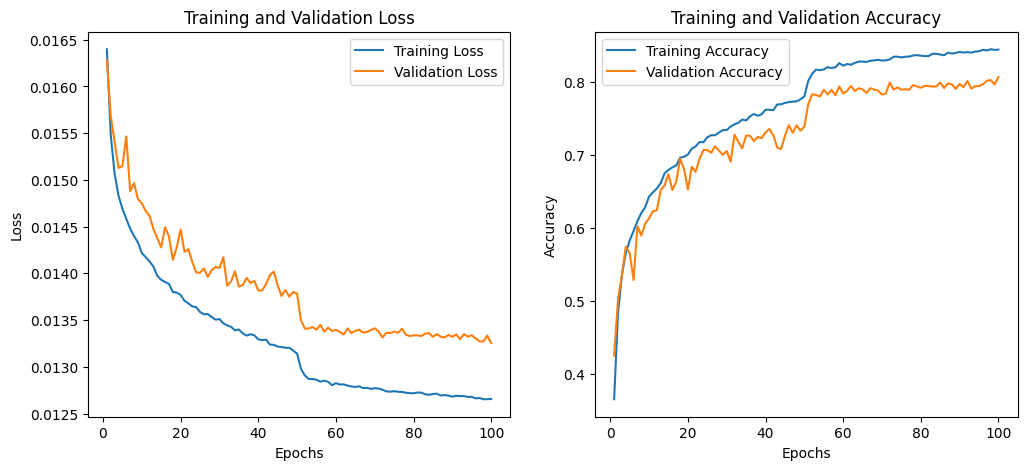

In [ ]:
# Plotting
epochs_range = range(1, epochs + 1)

# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
torch.save(model.state_dict(), 'trained_MyResNet_BN.pth')

# Metrics

In [4]:
!git clone https://github.com/K-Hooshanfar/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 143 (delta 82), reused 33 (delta 9), pack-reused 0
Receiving objects: 100% (143/143), 144.63 KiB | 5.36 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex
import torch
from tqdm import tqdm

In [5]:
# Load the pre-trained model
state_dict = torch.load('/content/trained_MyResNet_BN.pth')

model = MyResNet()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Convert test_dataset to a list or NumPy array
test_data_list = [(img, label) for img, label in test_dataset]

# Further split train_dataset into train_loader_dataset and 10% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.1 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Similarly, for the test_loader
test_loader_dataset, _ = train_test_split(test_data_list, train_size=int(0.1 * len(test_dataset)),
                                          test_size=None, shuffle=True, stratify=test_dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_loader_dataset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
features_per_layer = {}
labels = []

# Get the total number of layers in the model
total_layers = len(list(model.children()))

# Exclude the last four layers
layers_to_be_deleted = set(list(model.children())[-4:])

# Attach hooks to each layer except the excluded ones
features_per_layer = {}
for name, layer in model.named_children():
    if layer not in layers_to_be_deleted:
        features_per_layer[name] = []
        def hook(module, input, output, name=name):
            features_per_layer[name].append(output.detach())
        layer.register_forward_hook(hook)

In [11]:
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, targets in tqdm(train_loader):
        inputs = inputs.to(device)
        model(inputs)
        labels.append(targets.cpu())

# Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])

labels = torch.cat(labels)

100%|██████████| 32/32 [00:01<00:00, 20.71it/s]


# SI

In [12]:
si_train = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=1000)
    si_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 799.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3309.90it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1176.00it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1717.43it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4165.98it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4214.53it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4371.80it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3185.22it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4449.72it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3800.57it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3587.94it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4110.45it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2391.01it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1817.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1654.17it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1630.12it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4927.52it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4081.65it/s]


In [13]:
si_train

[('conv1', 0.21382716298103333),
 ('bn1', 0.21382716298103333),
 ('activation1', 0.2123456746339798),
 ('conv2', 0.19777777791023254),
 ('bn2', 0.19777777791023254),
 ('activation2', 0.1958024650812149),
 ('maxpool1', 0.2822222113609314),
 ('resblock1', 0.33530864119529724),
 ('maxpool2', 0.42641976475715637),
 ('conv3', 0.37481480836868286),
 ('bn3', 0.37481480836868286),
 ('activation3', 0.3883950710296631),
 ('maxpool3', 0.5634567737579346),
 ('conv4', 0.5081481337547302),
 ('bn4', 0.5081481337547302),
 ('activation4', 0.5279012322425842),
 ('resblock2', 0.7219753265380859),
 ('avgpool', 0.7696296572685242)]

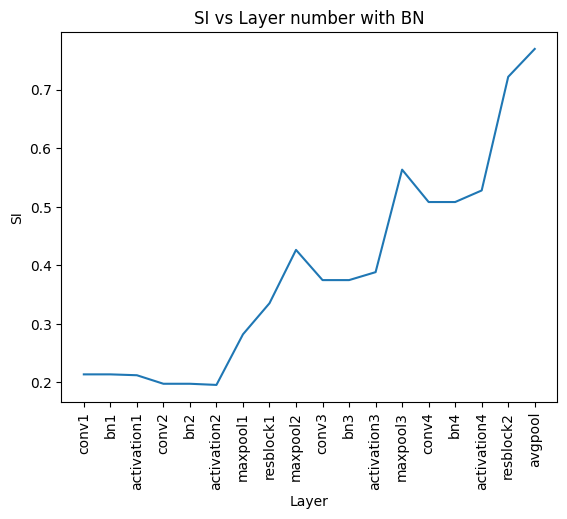

In [14]:
plt.plot([layer for layer, _ in si_train], [si for _, si in si_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('SI vs Layer number with BN')
plt.xticks(rotation=90)
plt.show()

# Center Si

In [15]:
csi_train = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=1000)
    csi_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2177.05it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2478.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1709.59it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 363.45it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1232.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1216.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1225.26it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3270.16it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2293.22it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1421.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1585.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1891.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1190.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1580.73it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1245.04it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1574.67it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1715.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 595.78it/s]


In [16]:
csi_train

[('conv1', 0.38098764419555664),
 ('bn1', 0.38098764419555664),
 ('activation1', 0.39950618147850037),
 ('conv2', 0.42543208599090576),
 ('bn2', 0.42543208599090576),
 ('activation2', 0.43703705072402954),
 ('maxpool1', 0.49753087759017944),
 ('resblock1', 0.5837036967277527),
 ('maxpool2', 0.6039506196975708),
 ('conv3', 0.583456814289093),
 ('bn3', 0.583456814289093),
 ('activation3', 0.5883950591087341),
 ('maxpool3', 0.6609876751899719),
 ('conv4', 0.6135802268981934),
 ('bn4', 0.6135802268981934),
 ('activation4', 0.621975302696228),
 ('resblock2', 0.8088889122009277),
 ('avgpool', 0.8276543021202087)]

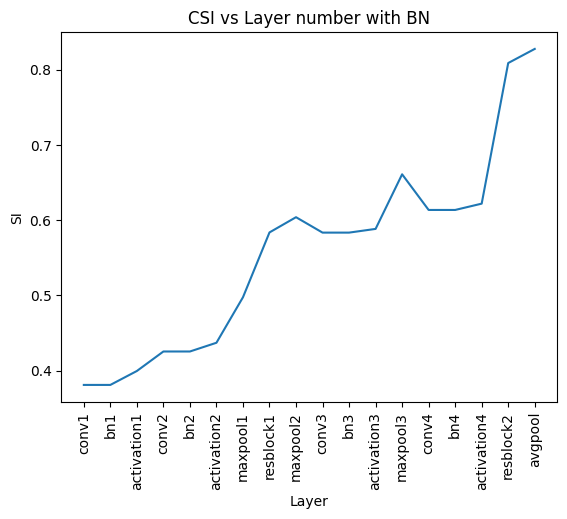

In [17]:
plt.plot([layer for layer, _ in csi_train], [si for _, si in csi_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('CSI vs Layer number with BN')
plt.xticks(rotation=90)
plt.show()

# Metrics of Test Loader

In [9]:
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to(device)
        model(inputs)
        labels.append(targets.cpu())

# Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])

labels = torch.cat(labels)

100%|██████████| 8/8 [00:02<00:00,  3.26it/s]


# SI

In [10]:
si_test = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=1000)
    si_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 699.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 923.65it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 891.65it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2299.51it/s]

Data has been normalized



Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2312.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2663.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2616.53it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2646.25it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2216.86it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1899.59it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 661.35it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2313.46it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2918.79it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1019.77it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 3041.55it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2493.64it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2845.53it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2926.94it/s]


In [11]:
si_test

[('conv1', 0.20000000298023224),
 ('bn1', 0.20000000298023224),
 ('activation1', 0.198888897895813),
 ('conv2', 0.1922222226858139),
 ('bn2', 0.1922222226858139),
 ('activation2', 0.18444444239139557),
 ('maxpool1', 0.23888888955116272),
 ('resblock1', 0.2644444406032562),
 ('maxpool2', 0.3222222328186035),
 ('conv3', 0.2800000011920929),
 ('bn3', 0.2800000011920929),
 ('activation3', 0.30222222208976746),
 ('maxpool3', 0.4399999976158142),
 ('conv4', 0.3955555558204651),
 ('bn4', 0.3955555558204651),
 ('activation4', 0.4144444465637207),
 ('resblock2', 0.6222222447395325),
 ('avgpool', 0.6877778172492981)]

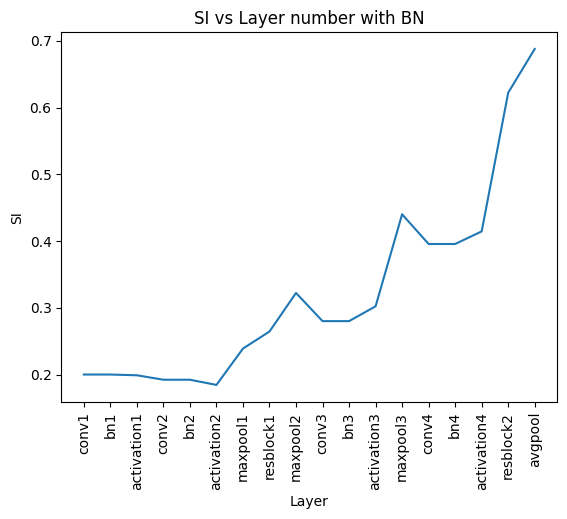

In [13]:
plt.plot([layer for layer, _ in si_test], [si for _, si in si_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('SI vs Layer number with BN')
plt.xticks(rotation=90)
plt.show()

# Center Si

In [14]:
csi_test = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=1000)
    csi_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 169.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 646.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 241.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 362.86it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 513.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 336.86it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 85.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 545.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 674.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 101.06it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1572.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 790.19it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 892.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 975.42it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 994.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 869.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 172.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1558.06it/s]


In [15]:
csi_test

[('conv1', 0.5022222399711609),
 ('bn1', 0.5022222399711609),
 ('activation1', 0.5233333706855774),
 ('conv2', 0.601111114025116),
 ('bn2', 0.601111114025116),
 ('activation2', 0.5955555438995361),
 ('maxpool1', 0.6133333444595337),
 ('resblock1', 0.6966666579246521),
 ('maxpool2', 0.7077777981758118),
 ('conv3', 0.6966666579246521),
 ('bn3', 0.6966666579246521),
 ('activation3', 0.7066667079925537),
 ('maxpool3', 0.7288889288902283),
 ('conv4', 0.6899999976158142),
 ('bn4', 0.6899999976158142),
 ('activation4', 0.698888897895813),
 ('resblock2', 0.7911111116409302),
 ('avgpool', 0.7766667008399963)]

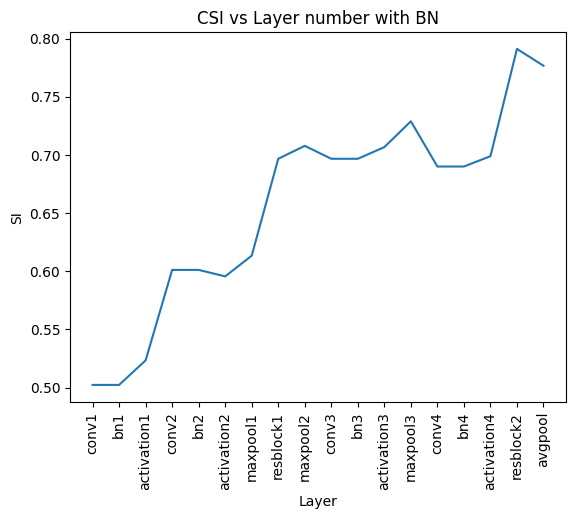

In [16]:
plt.plot([layer for layer, _ in csi_test], [si for _, si in csi_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('CSI vs Layer number with BN')
plt.xticks(rotation=90)
plt.show()